In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

# Load the dataset
data = pd.read_csv('diabetes 2.csv')

print("Initial dataset shape:", data.shape)

Initial dataset shape: (768, 9)


/Users/shubhamlaxmikantdeshmukh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


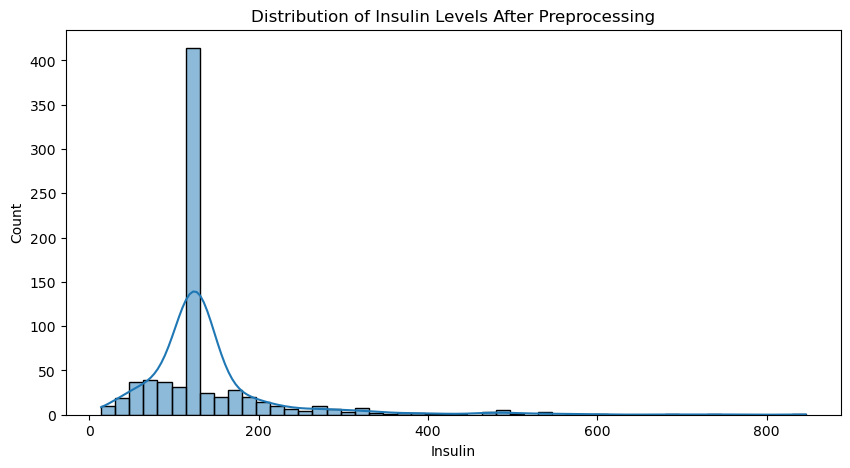

/Users/shubhamlaxmikantdeshmukh/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


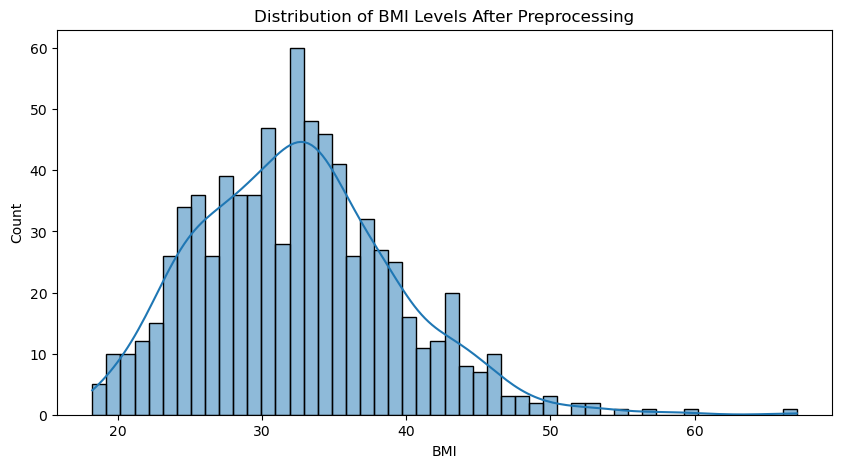

In [2]:
# Replace zeros in critical features (Insulin and BMI)
data['Insulin'] = data['Insulin'].replace(0, np.nan)
data['BMI'] = data['BMI'].replace(0, np.nan)

# Fill missing values with median of non-zero values
data['Insulin'].fillna(data['Insulin'].median(), inplace=True)
data['BMI'].fillna(data['BMI'].median(), inplace=True)

# Visualize distributions
plt.figure(figsize=(10, 5))
sns.histplot(data['Insulin'], kde=True, bins=50)
plt.title("Distribution of Insulin Levels After Preprocessing")
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(data['BMI'], kde=True, bins=50)
plt.title("Distribution of BMI Levels After Preprocessing")
plt.show()


/Users/shubhamlaxmikantdeshmukh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


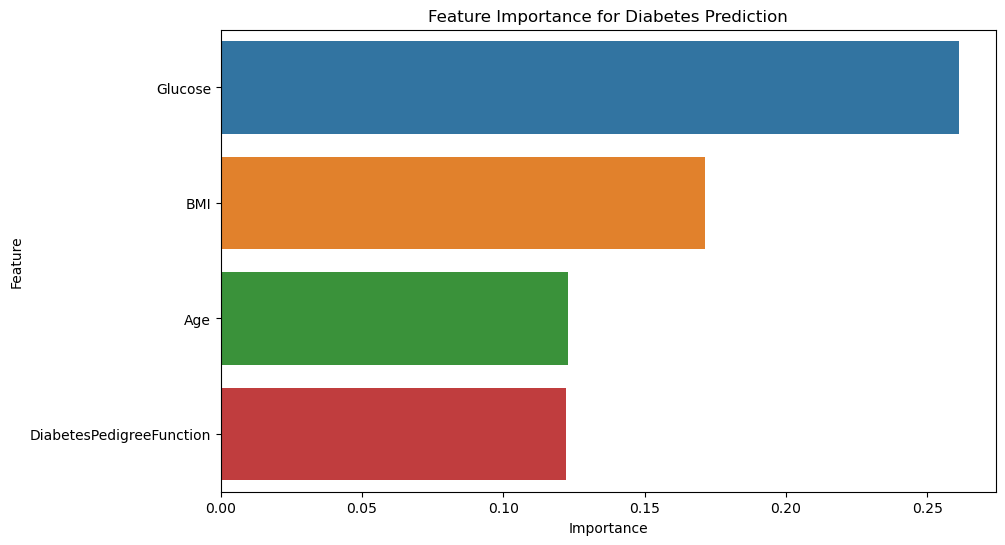

In [3]:
# Feature importance using RandomForest
X = data.drop(columns=['Outcome'])
y = data['Outcome']

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Automated feature selection
selector = SelectFromModel(rf_model, threshold='median', prefit=True)
X_selected = selector.transform(X)
selected_features = X.columns[selector.get_support()]

# Plot feature importances
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf_model.feature_importances_[selector.get_support()]
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance for Diabetes Prediction')
plt.show()

X = data[selected_features]


In [4]:
# Apply SMOTE for class balancing
print("Class distribution before SMOTE:")
print(y.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Class distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

# Scale features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
joblib.dump(scaler, 'scaler.pkl')


Class distribution before SMOTE:
Outcome
0    500
1    268
Name: count, dtype: int64
Class distribution after SMOTE:
Outcome
1    500
0    500
Name: count, dtype: int64


['scaler.pkl']

Final Model Performance
Accuracy: 0.825
Precision: 0.7844827586206896
Recall: 0.900990099009901
F1-Score: 0.8387096774193549
              precision    recall  f1-score   support

           0       0.88      0.75      0.81        99
           1       0.78      0.90      0.84       101

    accuracy                           0.82       200
   macro avg       0.83      0.82      0.82       200
weighted avg       0.83      0.82      0.82       200

Model saved as diabetes_classification_model.pkl


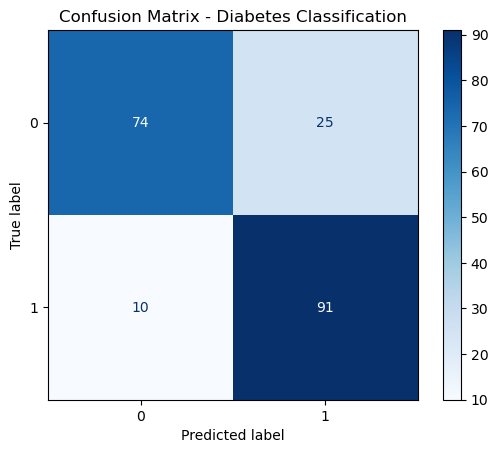

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Train the best model
best_model = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Model evaluation
print("Final Model Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save the model
joblib.dump(best_model, 'diabetes_classification_model.pkl')
print("Model saved as diabetes_classification_model.pkl")

# Confusion Matrix Visualization
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix - Diabetes Classification')
plt.show()



In [6]:
# Step 2: Self-labeling for Type 1 and Type 2 Diabetes Classification
data['Diabetes_Type'] = data.apply(lambda row:
    'Type 1' if (row['Insulin'] <= 50 and row['BMI'] < 25) else
    'Type 2' if (row['Insulin'] >= 100 and row['BMI'] >= 30) else
    'Unknown', axis=1)

print("Diabetes type distribution before filtering:")
print(data['Diabetes_Type'].value_counts())

# Remove unknown classifications
data = data[data['Diabetes_Type'] != 'Unknown']
print("Diabetes type distribution after filtering:")
print(data['Diabetes_Type'].value_counts())

data['Diabetes_Type'] = LabelEncoder().fit_transform(data['Diabetes_Type'])

X2 = data[selected_features]
y2 = data['Diabetes_Type']

# Apply SMOTE for class balancing
print("Class distribution before SMOTE:")
print(y2.value_counts())

if len(y2.unique()) > 1:
    smote = SMOTE(random_state=42)
    X2_resampled, y2_resampled = smote.fit_resample(X2, y2)
else:
    X2_resampled, y2_resampled = X2, y2

print("Class distribution after SMOTE:")
print(pd.Series(y2_resampled).value_counts())



Diabetes type distribution before filtering:
Diabetes_Type
Type 2     406
Unknown    350
Type 1      12
Name: count, dtype: int64
Diabetes type distribution after filtering:
Diabetes_Type
Type 2    406
Type 1     12
Name: count, dtype: int64
Class distribution before SMOTE:
Diabetes_Type
1    406
0     12
Name: count, dtype: int64
Class distribution after SMOTE:
Diabetes_Type
1    406
0    406
Name: count, dtype: int64


Step 2 - Type 1 vs Type 2 Diabetes Classification
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        77

    accuracy                           1.00       163
   macro avg       1.00      1.00      1.00       163
weighted avg       1.00      1.00      1.00       163

Model saved as diabetes_type_classification_model.pkl


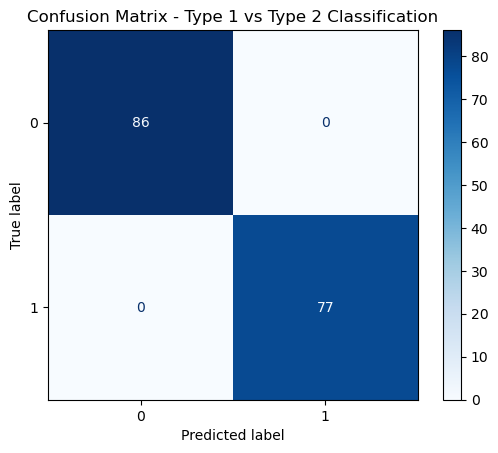

In [7]:
X2_scaled = scaler.transform(X2_resampled)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2_resampled, test_size=0.2, random_state=42)

# Train Type 1 vs Type 2 classifier
model_step2 = RandomForestClassifier(n_estimators=100, random_state=42)
model_step2.fit(X2_train, y2_train)
y2_pred = model_step2.predict(X2_test)

# Model evaluation for Type classification
print("Step 2 - Type 1 vs Type 2 Diabetes Classification")
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print("Precision:", precision_score(y2_test, y2_pred, average='weighted'))
print("Recall:", recall_score(y2_test, y2_pred, average='weighted'))
print("F1-Score:", f1_score(y2_test, y2_pred, average='weighted'))
print(classification_report(y2_test, y2_pred))

# Save the second model
joblib.dump(model_step2, 'diabetes_type_classification_model.pkl')
print("Model saved as diabetes_type_classification_model.pkl")

# Confusion Matrix for Type 1 vs Type 2 Classification
ConfusionMatrixDisplay.from_estimator(model_step2, X2_test, y2_test, cmap='Blues')
plt.title('Confusion Matrix - Type 1 vs Type 2 Classification')
plt.show()
